# Tensorflow Tutorial (MNIST)
## Neural Networks (TU Graz 2018)
(Adapted from the documentation of tensorflow, www.tensorflow.org)


In this tutorial weclassify images of digits from 0 to 9.
We use tensorflow and its capacity to perform symbolic calculus to implement a gradient descent optimization in a few lines of code. In general the main advantages of tensorflow are the following:
- Generation of C++ code that will be run on demand
- Symbolic calculus with automatic computation of gradients
- Transparent implementation on GPUs

In [1]:
%matplotlib inline

First import the packages and the MNIST dataset.

In [2]:
import tensorflow as tf
import numpy as np
import numpy.random as rd
import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

C:\Users\Legi\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
print(mnist.train.images.shape)
print(mnist.test.images.shape)
print(mnist.train.labels.shape)
print(mnist.test.labels.shape)

(55000, 784)
(10000, 784)
(55000, 10)
(10000, 10)


Each image is interpreted as a vector of size 784, each coefficient represent the gray level of the pixels, rescaled between 0 and 1.

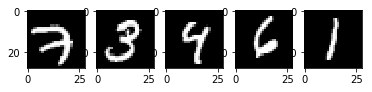

In [4]:
fig,ax_list = plt.subplots(1,5)
for k in range(5): ax_list[k].imshow(mnist.train.images[k,:].reshape(28,28), cmap='gray')

To classify the images we will use a softmax model that estimates $p(y= \text{label }| x=\text{image})$
- A linear transformation projects each input vector (i.e. each image) into 10 numbers using the matrix W and the bias b.
- A softmax function changes these numbers into probabilities of remaining to each category in {0, .. 9}
<img src="tf_tutorial_softmax.png" style="width: 500px;"/>

In terms of matrices it can be formalized:
- W and b are variables (tf.variable)
- x represent the input vectors (tf.placeholder)
- y is the output of the model (tf.Tensor also called an "op")
<img src="tf_tutorial_softmax_matrices.png" style="width: 500px;"/>

Note that x is a matrix and not a vector, is has shape [None,784]. The first dimension correspond to a **batch size**. Multiplying larger matrices is usually faster that multiplying small ones many times, using minibatches allows to process many images in a single matrix multiplication.

In [5]:
W = tf.Variable(rd.randn(784,10),trainable=True)
b = tf.Variable(np.zeros(10),trainable=True)

x = tf.placeholder(shape=(None,784),dtype=tf.float64)
y = tf.nn.softmax(tf.matmul(x,W) + b)

Define the loss function of the model. 

We choose the cross-entropy: $loss = - \sum y \log y'$

In [6]:
y_ = tf.placeholder(shape=(None,10),dtype=tf.float64)
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))

Note that until now everything is symbolic. ``x,y, y_`` and ``cross_entropy`` do not have a value.

In [7]:
y # This is called an "op" in tensorflow it is a symbolic tensor

<tf.Tensor 'Softmax:0' shape=(?, 10) dtype=float64>

In [8]:
tf.gradients(cross_entropy, b)[0] # It is also possible to compute the gradient of a tensor w.r.t some other tensor

<tf.Tensor 'gradients/add_grad/Reshape_1:0' shape=(10,) dtype=float64>

There is even an object to compute the a step of gradient descent directly. Each time it will be run it will:
- compute the gradient $\frac{\partial J}{\partial \theta}$ for all variable $\theta$
- update each varible as: $\theta \leftarrow \theta - \alpha \frac{\partial J}{\partial \theta}$

In [8]:
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy) # It only updates variable with it is run

## How to actually compute the value of a tensor or assign a variable ?
Until now all the variables are symbolic.
How can one actually evaluate the value of a Tensor ?

In [9]:
init = tf.global_variables_initializer() # Create an op that will initialize the variable on demand
sess = tf.Session()
sess.run(init) # Call for initilization

Evaluate and assign a new value to a Variable

In [10]:
b

<tf.Variable 'Variable_1:0' shape=(10,) dtype=float64_ref>

In [11]:
sess.run(b)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [12]:
change_b = tf.assign(b,np.ones(10))

In [13]:
sess.run(b)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [14]:
sess.run(change_b)
sess.run(b)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [15]:
sess.run(cross_entropy, feed_dict={x:mnist.train.images, y_:mnist.train.labels})

15.791558800761443

In [16]:
sess.run(cross_entropy, feed_dict={x:mnist.test.images, y_:mnist.test.labels})

16.21920152704447

## How to train the network ?

In [17]:
# Re init variables to start from scratch
sess.run(init)

# Create lists for monitoring
test_error_list = []
train_error_list = []

for k in range(20):
    # Compute a gradient step
    sess.run(train_step, feed_dict={x:mnist.train.images, y_:mnist.train.labels} )
    
    # Compute the losses on training and testing sets for monitoring
    train_err = sess.run(cross_entropy, feed_dict={x:mnist.train.images, y_:mnist.train.labels})
    test_err = sess.run(cross_entropy, feed_dict={x:mnist.test.images, y_:mnist.test.labels})
    test_error_list.append(test_err)
    train_error_list.append(train_err)

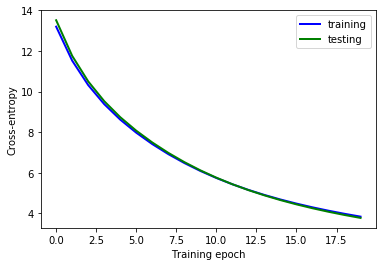

In [18]:
fig,ax = plt.subplots(1)
ax.plot(train_error_list, color='blue', label='training', lw=2)
ax.plot(test_error_list, color='green', label='testing', lw=2)
ax.set_xlabel('Training epoch')
ax.set_ylabel('Cross-entropy')
plt.legend()

For this dataset, training on minibatches accelerates the convergence.

In [19]:
# Re init variables to start from scratch
sess.run(init)

# Create some list to monitor how error decreases
test_error_list = []
train_error_list = []

# Create minibtaches to train faster
k_batch = 1000
X_batch_list = np.array_split(mnist.train.images,k_batch)
labels_batch_list = np.array_split(mnist.train.labels,k_batch)

for k in range(20):
    # Run gradient steps over each minibatch
    for x_minibatch,labels_minibatch in zip(X_batch_list,labels_batch_list):
        sess.run(train_step, feed_dict={x: x_minibatch, y_:labels_minibatch})
        
    # Compute the errors over the whole dataset
    train_err = sess.run(cross_entropy, feed_dict={x:mnist.train.images, y_:mnist.train.labels})
    test_err = sess.run(cross_entropy, feed_dict={x:mnist.test.images, y_:mnist.test.labels})
    
    # Put it into the lists
    test_error_list.append(test_err)
    train_error_list.append(train_err)

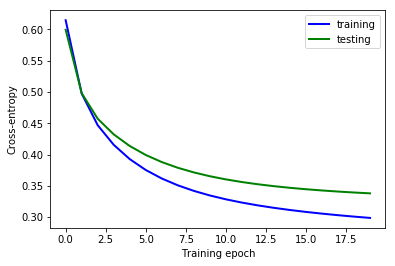

In [20]:
fig,ax = plt.subplots(1)
ax.plot(train_error_list, color='blue', label='training', lw=2)
ax.plot(test_error_list, color='green', label='testing', lw=2)
ax.set_xlabel('Training epoch')
ax.set_ylabel('Cross-entropy')
plt.legend()

It is better to quantify the performance in terms of percentage of success of the classifier.
The softmax is therefore replaced by an argmax to strictly get the category with highest probability for each image, and we count the number of imaged classified correctly.

In [22]:
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float64))

Yet tenserflow can only minimize differentiable functions, therefore we use the cross-entropy for the gradient descent steps and the accuracy for monitoring.

In [23]:
# Re init variables to start from scratch
sess.run(init)

# Create some list to monitor how error decreases
test_error_list = []
train_error_list = []

test_acc_list = []
train_acc_list = []

# Create minibtaches to train faster
k_batch = 100
X_batch_list = np.array_split(mnist.train.images,k_batch)
labels_batch_list = np.array_split(mnist.train.labels,k_batch)

for k in range(20):
    # Run gradient steps over each minibatch
    for x_minibatch,labels_minibatch in zip(X_batch_list,labels_batch_list):
        sess.run(train_step, feed_dict={x: x_minibatch, y_:labels_minibatch})
        
    # Compute the errors over the whole dataset
    train_err = sess.run(cross_entropy, feed_dict={x:mnist.train.images, y_:mnist.train.labels})
    test_err = sess.run(cross_entropy, feed_dict={x:mnist.test.images, y_:mnist.test.labels})
    
    # Compute the acc over the whole dataset
    train_acc = sess.run(accuracy, feed_dict={x:mnist.train.images, y_:mnist.train.labels})
    test_acc = sess.run(accuracy, feed_dict={x:mnist.test.images, y_:mnist.test.labels})
    
    # Put it into the lists
    test_error_list.append(test_err)
    train_error_list.append(train_err)
    test_acc_list.append(test_acc)
    train_acc_list.append(train_acc)

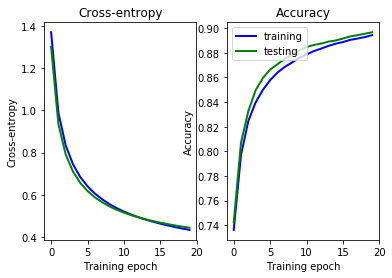

In [24]:
fig,ax_list = plt.subplots(1,2)
ax_list[0].plot(train_error_list, color='blue', label='training', lw=2)
ax_list[0].plot(test_error_list, color='green', label='testing', lw=2)
ax_list[1].plot(train_acc_list, color='blue', label='training', lw=2)
ax_list[1].plot(test_acc_list, color='green', label='testing', lw=2)

ax_list[0].set_title('Cross-entropy')
ax_list[0].set_xlabel('Training epoch')
ax_list[0].set_ylabel('Cross-entropy')
ax_list[1].set_title('Accuracy')
ax_list[1].set_xlabel('Training epoch')
ax_list[1].set_ylabel('Accuracy')
plt.legend(loc=2)